Objective: Predict whether a passenger was transported to an alternate dimension

To-do:

**Preprocessing**:

**Cleaning**:
- Fill missing values if any
- Drop duplicates if any
- Handle imbalances if any

**Feature Engineering**
- Group from PassengerId
- Side from Cabin
- TotalBill from RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Family from last name and group (?)
- Drop unneeded columns

Notes:
- PassengerId - Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## EDA

In [362]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (8693, 14)
Test shape: (4277, 13)


In [363]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [364]:
test.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

In [365]:
train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [366]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [367]:
nums = train.select_dtypes(exclude='object').columns.tolist()
cats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

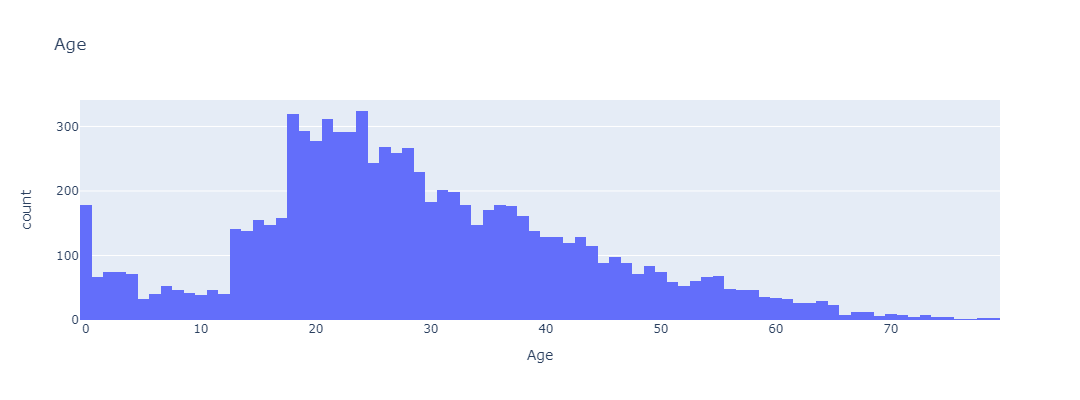

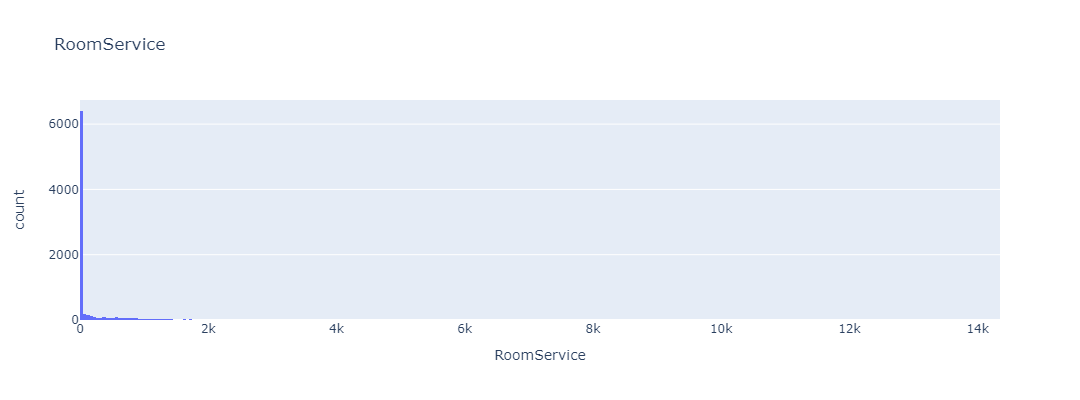

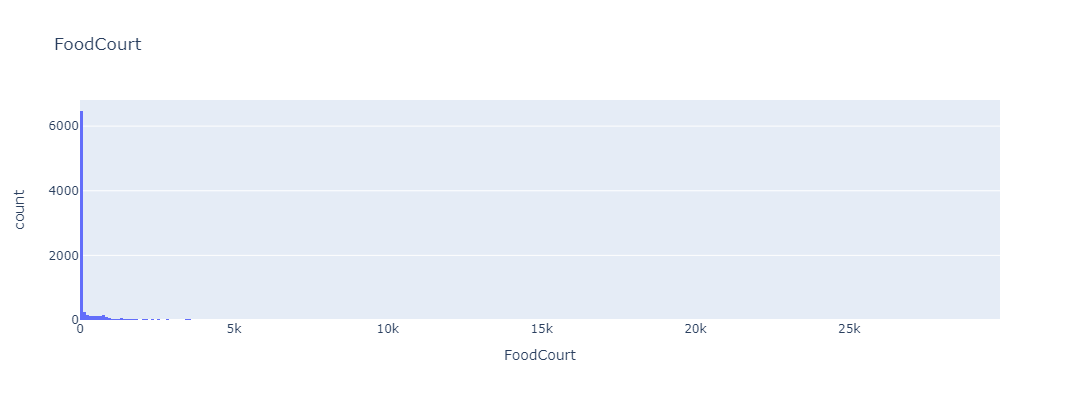

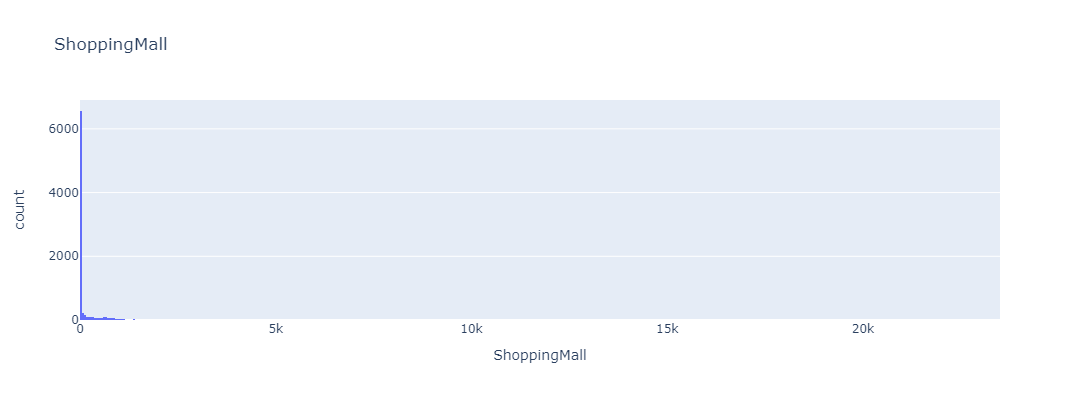

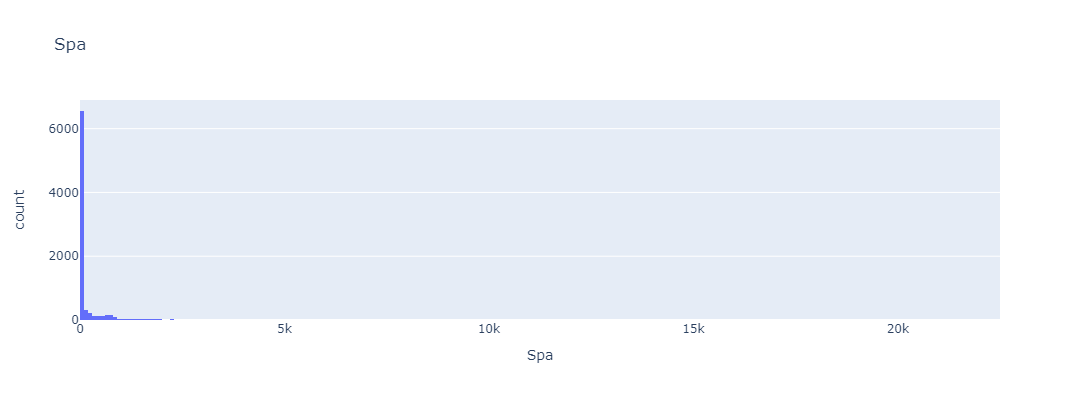

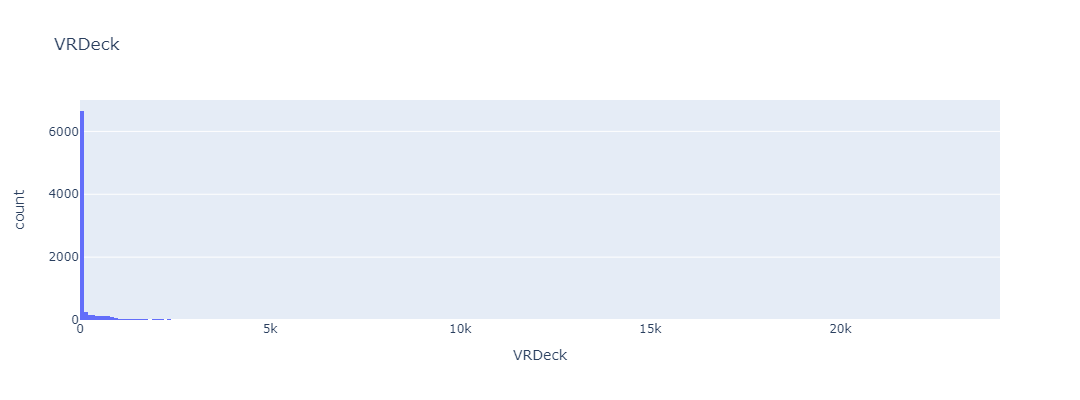

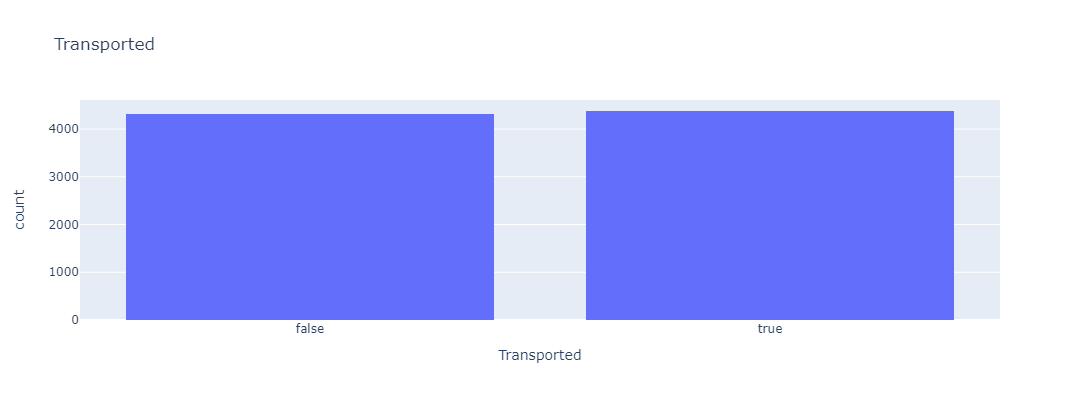

In [368]:
for i in train[nums]:
    fig = px.histogram(train, x = i, title = i, width=800, height=400)
    fig.show()

In [369]:
pd.pivot_table(train, index = 'Transported', values = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa'])

Age   FoodCourt  RoomService  ShoppingMall         Spa
Transported                                                              
False        29.922858  382.615930   389.266066    167.566217  564.382666
True         27.748834  532.691984    63.098021    179.829972   61.675531

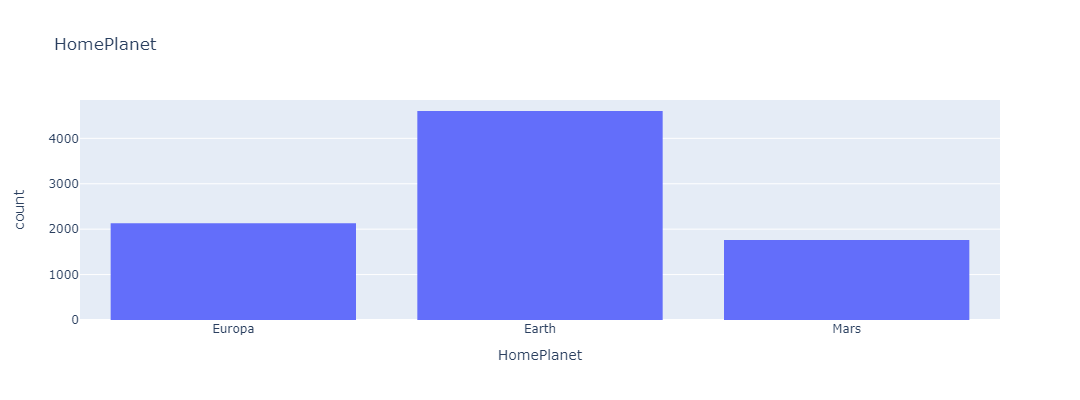

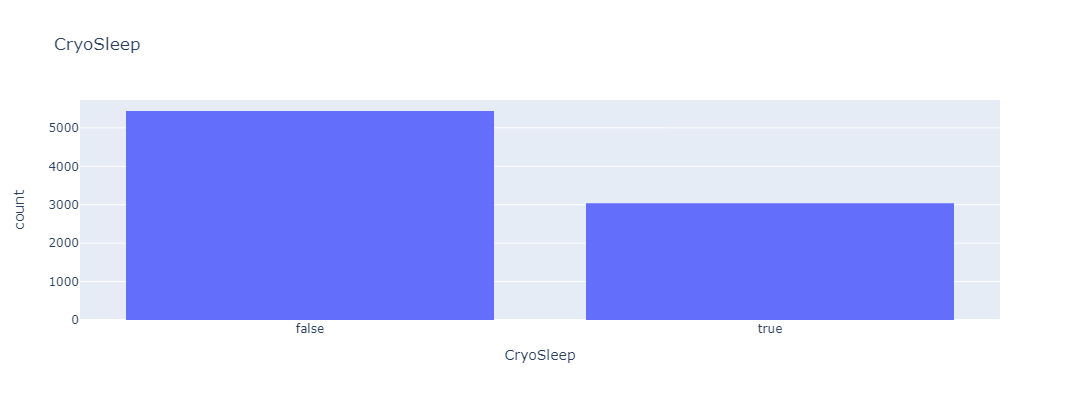

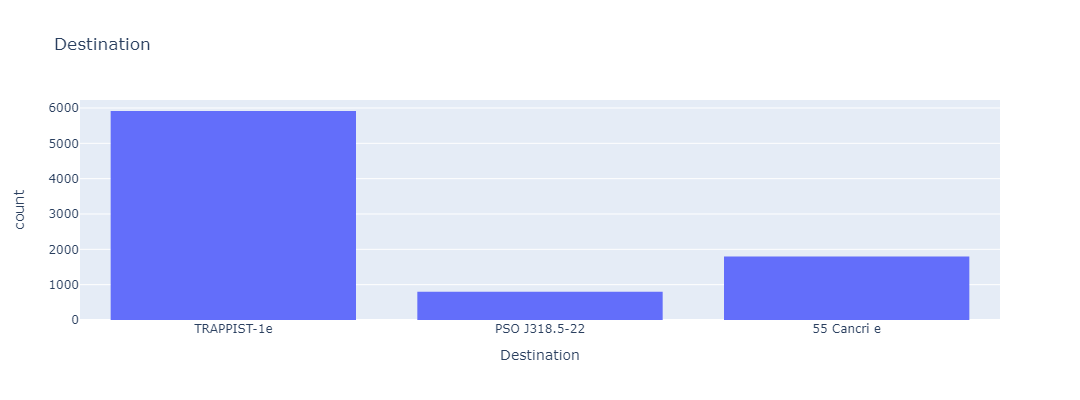

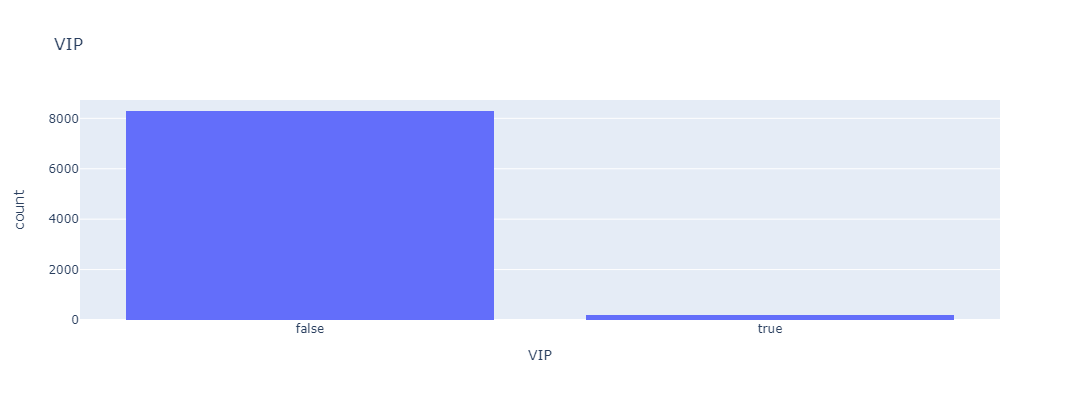

In [370]:
for i in train[cats]:
    fig = px.histogram(train, x = train[i], title = i, width = 800, height = 400)
    fig.show()

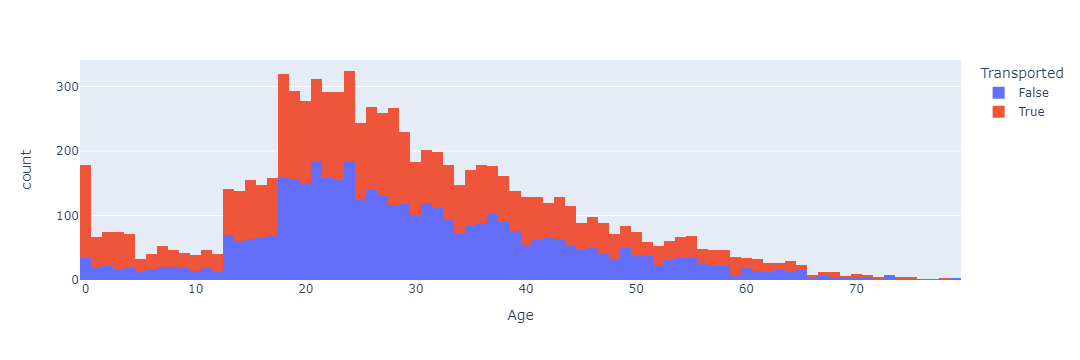

In [371]:
fig = px.histogram(train, x = 'Age', color = 'Transported')

fig.show()

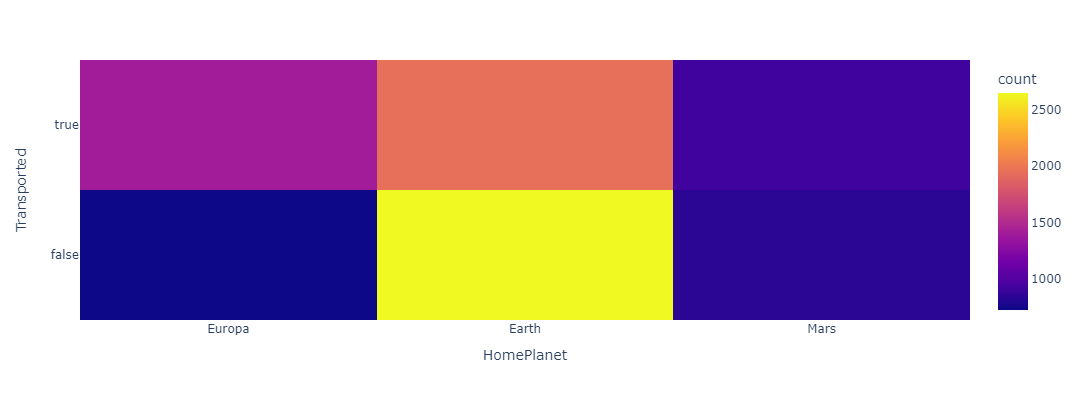

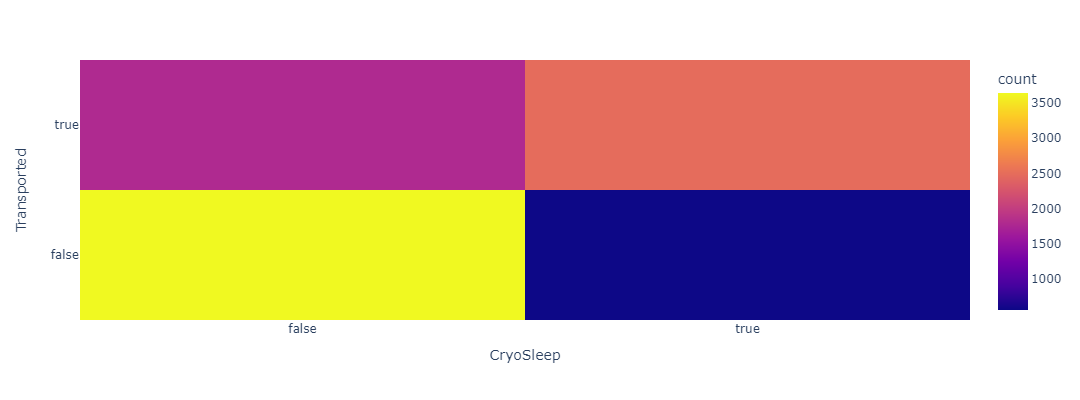

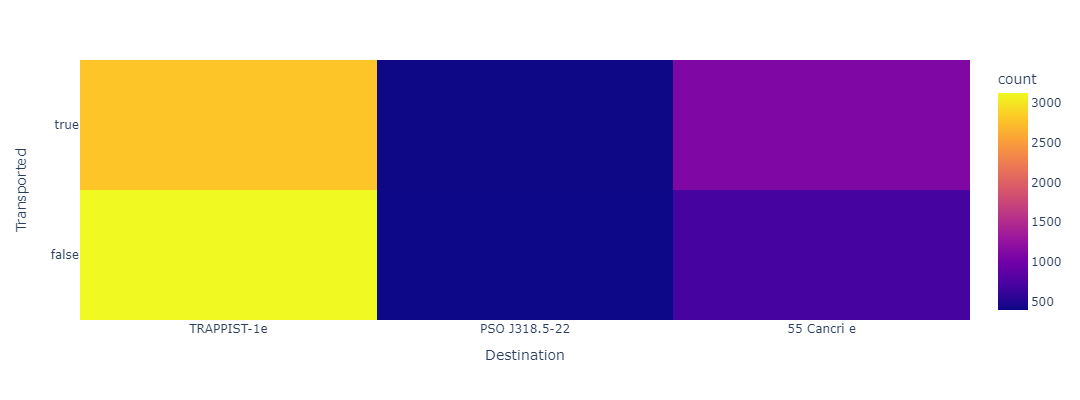

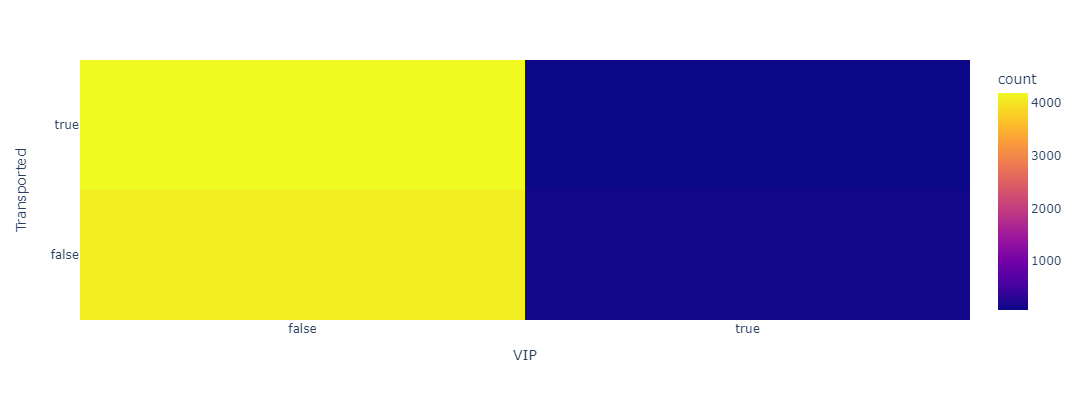

In [372]:
for i in train[cats]:
    fig = px.density_heatmap(train, x=i, y= 'Transported', width=800, height=400)
    fig.show()



In [ ]:
pd.pivot_table(train, index = 'Transported', columns = 'Age', values = 'HomePlanet', aggfunc = 'count')

## Preprocessing

In [374]:
def split_id(PassengerId):
    return str(PassengerId).split('_')

def split_cabin(Cabin):
    if len(str(Cabin).split('/')) < 3:
        return ["Unknown", "Unknown", "Unknown"]
    else:   
        return str(Cabin).split('/')

def split_name(Name):
    return str(Name).split(' ')

def with_family(df):
    df.loc[0, 'WithFamily'] = "False"
    for i in range(1, len(df)):
        if (df.loc[i, 'Group'] == df.loc[i-1, 'Group']) & (df.loc[i, 'LastName'] == df.loc[i-1, 'LastName']) & (df.loc[i, 'LastName'] != 'Unknown'):
            df.loc[i, 'WithFamily'] = "True"
            if (df.loc[i-1, 'Group'] == df.loc[i-1, 'Group']) & (df.loc[i-1, 'LastName'] == df.loc[i-1, 'LastName']) & (df.loc[i-1, 'WithFamily'] == "False"):
                df.loc[i-1, 'WithFamily'] = "True"
        else:
            df.loc[i, 'WithFamily'] = "False"

In [375]:
print('Train missing values:')
print(train.isnull().mean().sort_values(ascending = False) * 100)

print('Test missing values:')
print(test.isnull().mean().sort_values(ascending = False) * 100)

Train missing values:
CryoSleep       2.496261
ShoppingMall    2.392730
VIP             2.335212
HomePlanet      2.312205
Name            2.300702
Cabin           2.289198
VRDeck          2.162660
FoodCourt       2.105142
Spa             2.105142
Destination     2.093639
RoomService     2.082135
Age             2.059128
PassengerId     0.000000
Transported     0.000000
dtype: float64
Test missing values:
FoodCourt       2.478373
Spa             2.361468
Cabin           2.338087
ShoppingMall    2.291326
Name            2.197802
CryoSleep       2.174421
VIP             2.174421
Destination     2.151040
Age             2.127660
HomePlanet      2.034136
RoomService     1.917232
VRDeck          1.870470
PassengerId     0.000000
dtype: float64


In [376]:
def preprocessing(df):
    # Missing Values
    df['CryoSleep'].fillna('Unknown', inplace=True)
    df['ShoppingMall'].fillna(0, inplace=True)
    df['VIP'].fillna('Unknown', inplace=True)
    df['HomePlanet'].fillna('Unknown', inplace=True)
    df['Name'].fillna('Unknown Unknown', inplace=True)
    df['VRDeck'].fillna(0, inplace=True)
    df['FoodCourt'].fillna(0, inplace=True)
    df['Spa'].fillna(0, inplace=True)
    df['Destination'].fillna('Unknown', inplace=True)
    df['RoomService'].fillna(0, inplace=True)
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    
    #Feature Engineering
    df['SplitId'] = df['PassengerId'].apply(lambda x: split_id(x))
    df['Group'] = df['SplitId'].apply(lambda x: x[0])
    
    df['SplitCabin'] = df['Cabin'].apply(lambda x: split_cabin(x))
    df['Deck'] = df['SplitCabin'].apply(lambda x: x[0])
    df['Side'] = df['SplitCabin'].apply(lambda x: x[2])
    
    df['SplitName'] = df['Name'].apply(lambda x: split_name(x))
    df['LastName'] = df['SplitName'].apply(lambda x: x[1])
    
    with_family(df)
    
    
    
    df.drop(['PassengerId','SplitId', 'Group', 'Cabin', 'SplitCabin', 'SplitName', 'LastName', 'Name'], axis=1, inplace=True) 
    # df.drop('Name', axis=1, inplace=True) 

In [377]:
preprocessing(train)

In [378]:
train.head()

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported Deck Side WithFamily  
0           0.0     0.0     0.0        False    B    P      False  
1          25.0   549.0    44.0         True    F    S      False  
2           0.0  6715.0    49.0        False    A    S       True  
3         371.0  3329.0   193.0        False    A    S       True  
4         151.0   565.0     2.0         True    F    S      False

In [379]:
train.loc[train['WithFamily'] == 'True']

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
2        Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3        Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
6         Earth     False  TRAPPIST-1e  26.0  False         42.0     1539.0   
7         Earth      True  TRAPPIST-1e  28.0  False          0.0        0.0   
9        Europa      True  55 Cancri e  14.0  False          0.0        0.0   
...         ...       ...          ...   ...    ...          ...        ...   
8685     Europa     False  TRAPPIST-1e   0.0  False          0.0        0.0   
8686     Europa     False  TRAPPIST-1e  32.0  False          1.0     1146.0   
8687     Europa   Unknown  TRAPPIST-1e  30.0  False          0.0     3208.0   
8691     Europa     False  55 Cancri e  32.0  False          0.0     1049.0   
8692     Europa     False  TRAPPIST-1e  44.0  False        126.0     4688.0   

      ShoppingMall     Spa  VRDeck  Transported Deck Side WithFamily  
2              0.0  6715.0    49.0        False    A    S       True  
3            371.0  3329.0   193.0        False    A    S       True  
6              3.0     0.0     0.0         True    F    S       True  
7              0.0     0.0     0.0         True    G    S       True  
9              0.0     0.0     0.0         True    B    P       True  
...            ...     ...     ...          ...  ...  ...        ...  
8685           0.0     0.0     0.0         True    A    P       True  
8686           0.0    50.0    34.0        False    A    P       True  
8687           0.0     2.0   330.0         True    A    P       True  
8691           0.0   353.0  3235.0        False    E    S       True  
8692           0.0     0.0    12.0         True    E    S       True  

[3242 rows x 14 columns]

In [380]:
train_processed = train.copy()

# Training Model

In [381]:
X = train_processed .drop('Transported', axis=1)
X = pd.get_dummies(X)
y = train_processed ['Transported']

In [382]:
X.head()

Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0  39.0          0.0        0.0           0.0     0.0     0.0   
1  24.0        109.0        9.0          25.0   549.0    44.0   
2  58.0         43.0     3576.0           0.0  6715.0    49.0   
3  33.0          0.0     1283.0         371.0  3329.0   193.0   
4  16.0        303.0       70.0         151.0   565.0     2.0   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  HomePlanet_Unknown  \
0                 0                  1                0                   0   
1                 1                  0                0                   0   
2                 0                  1                0                   0   
3                 0                  1                0                   0   
4                 1                  0                0                   0   

   CryoSleep_False  CryoSleep_True  CryoSleep_Unknown  \
0                1               0                  0   
1                1               0                  0   
2                1               0                  0   
3                1               0                  0   
4                1               0                  0   

   Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   

   Destination_TRAPPIST-1e  Destination_Unknown  VIP_False  VIP_True  \
0                        1                    0          1         0   
1                        1                    0          1         0   
2                        1                    0          0         1   
3                        1                    0          1         0   
4                        1                    0          1         0   

   VIP_Unknown  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  \
0            0       0       1       0       0       0       0       0   
1            0       0       0       0       0       0       1       0   
2            0       1       0       0       0       0       0       0   
3            0       1       0       0       0       0       0       0   
4            0       0       0       0       0       0       1       0   

   Deck_T  Deck_Unknown  Side_P  Side_S  Side_Unknown  WithFamily_False  \
0       0             0       1       0             0                 1   
1       0             0       0       1             0                 1   
2       0             0       0       1             0                 0   
3       0             0       0       1             0                 0   
4       0             0       0       1             0                 1   

   WithFamily_True  
0                0  
1                0  
2                1  
3                1  
4                0

In [386]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, test_size = 0.2,random_state = 42)

In [394]:
pipelines = {
    'xgb': make_pipeline(StandardScaler(), XGBClassifier(random_state = 42)),
    'lgbm': make_pipeline(StandardScaler(), LGBMClassifier(random_state = 42)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 42))
}

In [395]:
grid = {
    'xgb': {
        'xgbclassifier__n_estimators':[100,200,300]
    },
    'lgbm': {
        'lgbmclassifier__n_estimators':[100,200,300]
    }, 
    'rf': {
        'randomforestclassifier__n_estimators':[100,200,300]
    }
}

In [396]:
# Create a blank dictionary to hold the models 
fit_models = {}
# Loop through all the algos 
for algo, pipeline in pipelines.items():
  print(f'Training the {algo} model.')
  # Create new Grid Search CV Cclass 
  model = GridSearchCV(pipeline, grid[algo], n_jobs=-1, cv=10)
  # Train the model 
  model.fit(X_train, y_train)
  # Store results inside of the dictionary
  fit_models[algo] = model

Training the xgb model.
Training the lgbm model.
Training the rf model.


In [421]:
for algo, model in fit_models.items(): 
    yhat = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, yhat)
    precision = precision_score(y_valid, yhat)
    recall = recall_score(y_valid, yhat)
    f1 = f1_score(y_valid, yhat)
    print(f'Metrics for {algo}: accuracy- {accuracy}, recall- {recall}, precision- {precision}, f1- {f1}')

Metrics for xgb: accuracy- 0.780333525014376, recall- 0.7961275626423691, precision- 0.7749445676274944, f1- 0.7853932584269663
Metrics for lgbm: accuracy- 0.7935595169637722, recall- 0.816628701594533, precision- 0.7836065573770492, f1- 0.799776910206358
Metrics for rf: accuracy- 0.7797584818861415, recall- 0.7528473804100227, precision- 0.7992744860943168, f1- 0.7753665689149561


In [412]:
y = test.copy()

preprocessing(y)

In [413]:
y.head()

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0      Earth      True  TRAPPIST-1e  27.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  19.0  False          0.0        9.0   
2     Europa      True  55 Cancri e  31.0  False          0.0        0.0   
3     Europa     False  TRAPPIST-1e  38.0  False          0.0     6652.0   
4      Earth     False  TRAPPIST-1e  20.0  False         10.0        0.0   

   ShoppingMall     Spa  VRDeck Deck Side WithFamily  
0           0.0     0.0     0.0    G    S      False  
1           0.0  2823.0     0.0    F    S      False  
2           0.0     0.0     0.0    C    S      False  
3           0.0   181.0   585.0    C    S      False  
4         635.0     0.0     0.0    F    S      False

In [414]:
y_test = pd.get_dummies(y)

In [415]:
y_pred = fit_models['lgbm'].predict(y_test)


In [416]:
submission = pd.DataFrame([test['PassengerId'], y_pred]).T
submission.columns = ['PassengerID', 'Transported']

In [417]:
submission.head()

PassengerID Transported
0     0013_01        True
1     0018_01       False
2     0019_01        True
3     0021_01        True
4     0023_01        True

In [418]:
submission.to_csv('submission.csv', index=False)

In [419]:
!kaggle competitions submit -c spaceship-titanic -m "testing lgbm model" -f "submission.csv"

Successfully submitted to Spaceship Titanic



  0%|          | 0.00/60.5k [00:00<?, ?B/s]
 13%|#3        | 8.00k/60.5k [00:00<00:01, 47.5kB/s]
100%|##########| 60.5k/60.5k [00:03<00:00, 15.7kB/s]
